# Temporal Graph Dataset Analysis

This notebook provides a comprehensive analysis of temporal graph datasets generated from cow proximity RSSI data.

## Analysis Overview:
1. **Load Dataset** - Import temporal graphs, metadata, and summary statistics
2. **Network Statistics** - Compute graph metrics over time
3. **Visualizations** - Static and interactive plots
4. **Animations** - Show network evolution over time
5. **Centrality Analysis** - Identify influential cows
6. **Community Detection** - Find groups of closely connected cows
7. **Temporal Patterns** - Analyze how the network changes over time

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pickle
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# Network analysis
import networkx as nx
from networkx.algorithms import community

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistics
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Dataset

Load the temporal graph dataset files generated by `generate_temporal_graph_dataset.py`:
- `.pkl` file: Contains the temporal graphs
- `_metadata.json`: Configuration and summary information
- `_summary.csv`: Per-snapshot statistics

In [2]:
# Specify the base filename (without extension)
# Updated to the newly generated dataset with 30s snapshots
BASE_FILENAME = "temporal_graphs_rssi-75.0_snap30s_max_20251112_102656"
DATA_DIR = Path("outputs/temporal_graphs")

# File paths
pickle_file = DATA_DIR / f"{BASE_FILENAME}.pkl"
metadata_file = DATA_DIR / f"{BASE_FILENAME}_metadata.json"
summary_file = DATA_DIR / f"{BASE_FILENAME}_summary.csv"

print(f"📂 Loading dataset from: {DATA_DIR}")
print(f"   Files to load:")
print(f"   - {pickle_file.name}")
print(f"   - {metadata_file.name}")
print(f"   - {summary_file.name}")

📂 Loading dataset from: outputs/temporal_graphs
   Files to load:
   - temporal_graphs_rssi-75.0_snap30s_max_20251112_102656.pkl
   - temporal_graphs_rssi-75.0_snap30s_max_20251112_102656_metadata.json
   - temporal_graphs_rssi-75.0_snap30s_max_20251112_102656_summary.csv


In [3]:
# Load temporal graphs (pickle file)
print("\n📥 Loading temporal graphs...")
with open(pickle_file, 'rb') as f:
    temporal_graphs = pickle.load(f)

print(f"✅ Loaded {len(temporal_graphs)} temporal graph snapshots")

# Load metadata (JSON file)
print("\n📥 Loading metadata...")
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"✅ Metadata loaded:")
for key, value in metadata.items():
    print(f"   {key}: {value}")

# Load summary statistics (CSV file)
print("\n📥 Loading summary statistics...")
summary_df = pd.read_csv(summary_file)
summary_df['timestamp'] = pd.to_datetime(summary_df['timestamp'])

print(f"✅ Summary loaded: {len(summary_df)} rows")
print(f"\nFirst few rows:")
summary_df.head()


📥 Loading temporal graphs...
✅ Loaded 18720 temporal graph snapshots

📥 Loading metadata...
✅ Metadata loaded:
   rssi_threshold: -75.0
   snapshot_duration: 30
   aggregation: max
   num_snapshots: 18720
   start_time: 2025-03-17 12:00:00
   end_time: 2025-03-23 23:59:30
   total_nodes: 49
   created_at: 2025-11-12T10:26:58.018395

📥 Loading summary statistics...
✅ Summary loaded: 18720 rows

First few rows:


timestamp  num_nodes  num_edges  num_measurements
0 2025-03-17 12:00:00         49         69               472
1 2025-03-17 12:00:30         49         67               520
2 2025-03-17 12:01:00         49         65               448
3 2025-03-17 12:01:30         49         70               528
4 2025-03-17 12:02:00         49         72               481

## 3. Explore Dataset Structure

Examine the structure of the temporal graph data

In [4]:
# Examine first snapshot
first_snapshot = temporal_graphs[0]

print("📊 First Snapshot Structure:")
print(f"   Keys: {list(first_snapshot.keys())}")
print(f"   Timestamp: {first_snapshot['timestamp']}")
print(f"   Number of nodes: {first_snapshot['num_nodes']}")
print(f"   Number of edges: {first_snapshot['num_edges']}")
print(f"   Number of measurements: {first_snapshot['num_measurements']}")

# Examine the graph
G = first_snapshot['graph']
print(f"\n📈 Graph Details:")
print(f"   Type: {type(G)}")
print(f"   Nodes (cows): {list(G.nodes())[:10]}...")  # Show first 10
print(f"   Sample edges with RSSI:")
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"      {u} <-> {v}, RSSI: {data['rssi']:.2f} dB")

📊 First Snapshot Structure:
   Keys: ['timestamp', 'graph', 'num_nodes', 'num_edges', 'num_measurements']
   Timestamp: 2025-03-17 12:00:00
   Number of nodes: 49
   Number of edges: 69
   Number of measurements: 472

📈 Graph Details:
   Type: <class 'networkx.classes.graph.Graph'>
   Nodes (cows): ['3cf3', '3d03', '3cff', '3cfe', '3664', '3ce9', '3cf5', '3cec', '3cf6', '366b']...
   Sample edges with RSSI:
      3cf3 <-> 3660, RSSI: -75.00 dB
      3cf3 <-> 3cfa, RSSI: -70.00 dB
      3d03 <-> 366a, RSSI: -73.00 dB
      3d03 <-> 3cf8, RSSI: -73.00 dB
      3cff <-> 366b, RSSI: -73.00 dB


## 4. Statistical Summary of Network Metrics

Compute basic statistics for the temporal network

In [5]:
# Summary statistics from the CSV file
print("📊 Network Statistics Summary:")
print("\n" + "="*60)
print(summary_df[['num_nodes', 'num_edges', 'num_measurements']].describe())
print("="*60)

# Additional derived statistics
summary_df['density'] = summary_df.apply(
    lambda row: row['num_edges'] / (row['num_nodes'] * (row['num_nodes'] - 1) / 2) 
    if row['num_nodes'] > 1 else 0, 
    axis=1
)
summary_df['avg_degree'] = (2 * summary_df['num_edges']) / summary_df['num_nodes']

print(f"\n📈 Derived Metrics:")
print(f"   Average network density: {summary_df['density'].mean():.4f}")
print(f"   Average degree per cow: {summary_df['avg_degree'].mean():.2f}")
print(f"   Max edges in any snapshot: {summary_df['num_edges'].max()}")
print(f"   Min edges in any snapshot: {summary_df['num_edges'].min()}")

📊 Network Statistics Summary:

       num_nodes     num_edges  num_measurements
count    18720.0  18720.000000      18720.000000
mean        49.0     66.812286        544.732906
std          0.0     10.224162         68.813019
min         49.0      4.000000         41.000000
25%         49.0     60.000000        497.000000
50%         49.0     66.000000        541.000000
75%         49.0     73.000000        590.000000
max         49.0    114.000000        884.000000

📈 Derived Metrics:
   Average network density: 0.0568
   Average degree per cow: 2.73
   Max edges in any snapshot: 114
   Min edges in any snapshot: 4


## 5. Time Series Visualizations

Visualize how network metrics evolve over time

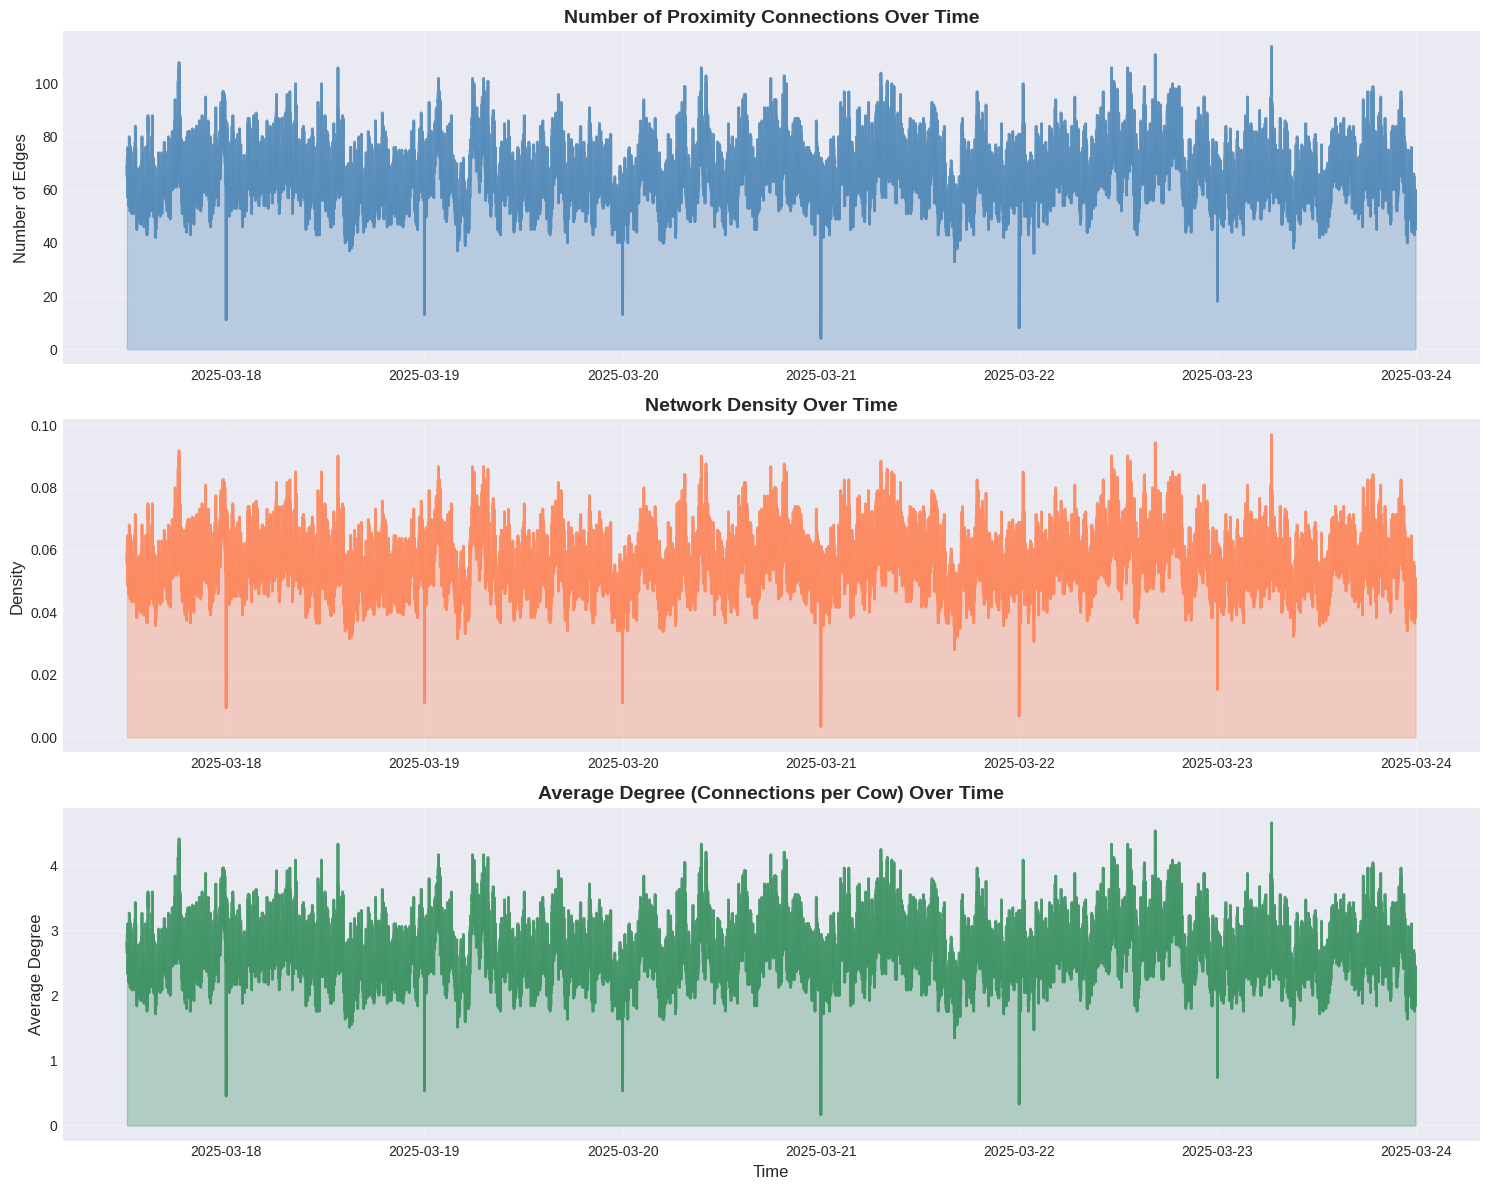

✅ Time series plots generated for 18720 snapshots


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Number of edges over time
axes[0].plot(summary_df['timestamp'], summary_df['num_edges'], 
             linewidth=2, color='steelblue', alpha=0.8)
axes[0].fill_between(summary_df['timestamp'], summary_df['num_edges'], 
                       alpha=0.3, color='steelblue')
axes[0].set_title('Number of Proximity Connections Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Edges', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Network density over time
axes[1].plot(summary_df['timestamp'], summary_df['density'], 
             linewidth=2, color='coral', alpha=0.8)
axes[1].fill_between(summary_df['timestamp'], summary_df['density'], 
                       alpha=0.3, color='coral')
axes[1].set_title('Network Density Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Density', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Average degree over time
axes[2].plot(summary_df['timestamp'], summary_df['avg_degree'], 
             linewidth=2, color='seagreen', alpha=0.8)
axes[2].fill_between(summary_df['timestamp'], summary_df['avg_degree'], 
                       alpha=0.3, color='seagreen')
axes[2].set_title('Average Degree (Connections per Cow) Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Average Degree', fontsize=12)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Time series plots generated for {len(summary_df)} snapshots")

## 6. Distribution Analysis

Analyze the distribution of key network metrics

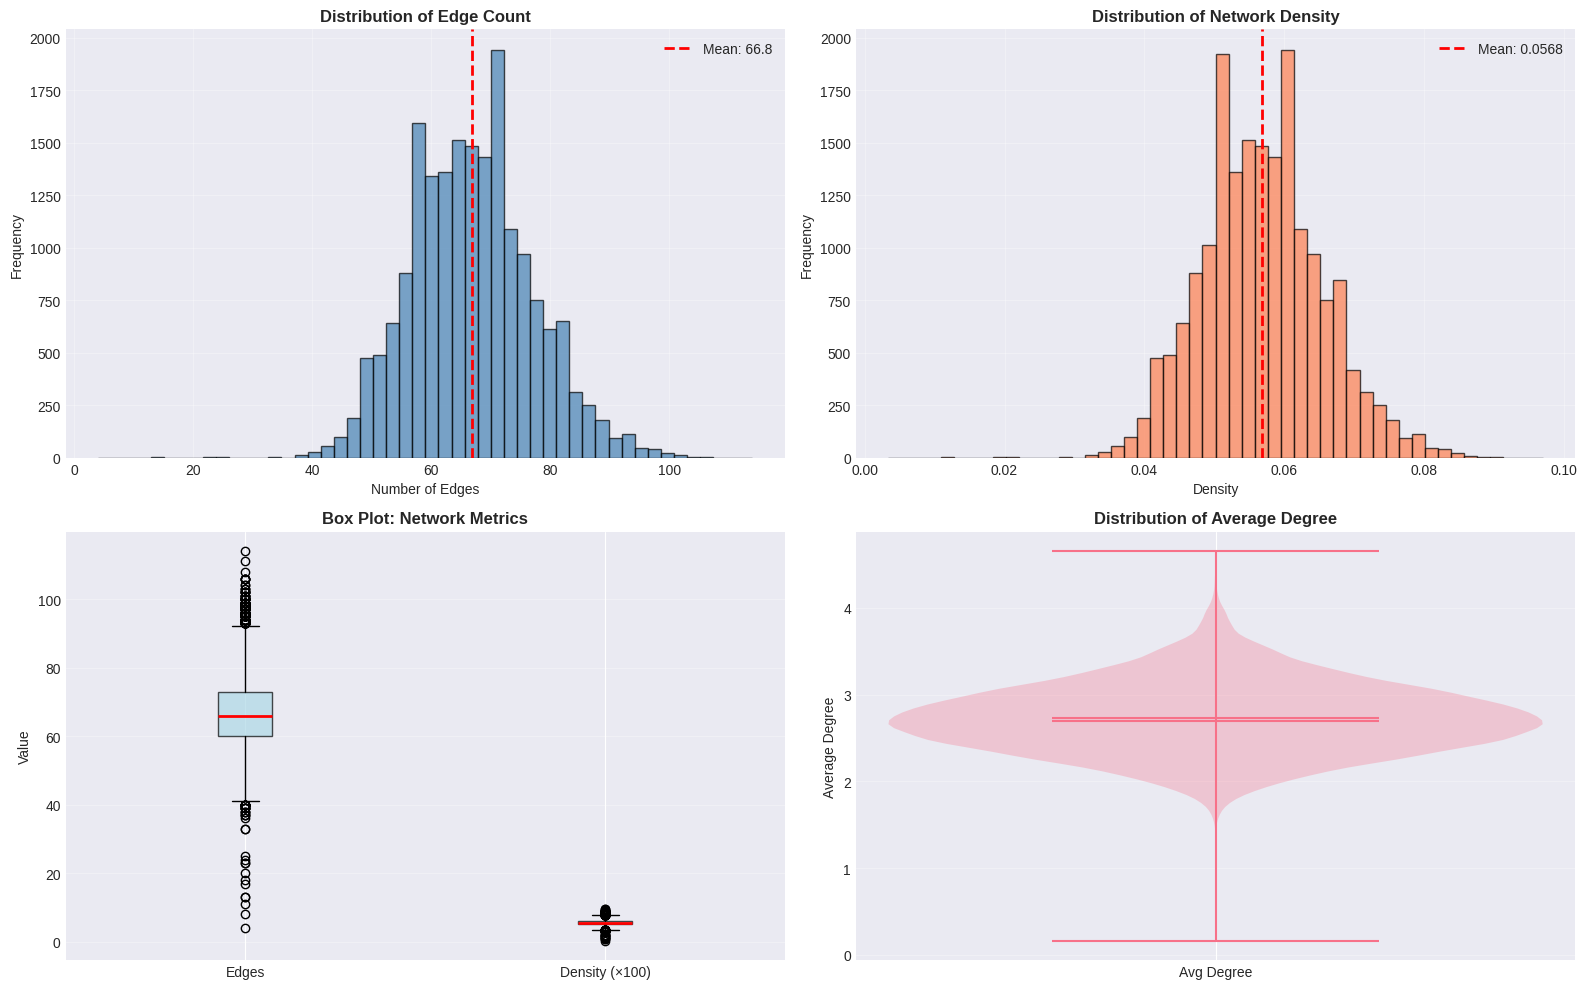

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram: Number of edges
axes[0, 0].hist(summary_df['num_edges'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(summary_df['num_edges'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {summary_df["num_edges"].mean():.1f}')
axes[0, 0].set_title('Distribution of Edge Count', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Edges')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogram: Network density
axes[0, 1].hist(summary_df['density'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(summary_df['density'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {summary_df["density"].mean():.4f}')
axes[0, 1].set_title('Distribution of Network Density', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Density')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot: Edges and density
box_data = [summary_df['num_edges'], summary_df['density'] * 100]
axes[1, 0].boxplot(box_data, labels=['Edges', 'Density (×100)'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_title('Box Plot: Network Metrics', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Violin plot: Average degree
axes[1, 1].violinplot([summary_df['avg_degree']], positions=[1], 
                       showmeans=True, showmedians=True)
axes[1, 1].set_title('Distribution of Average Degree', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Degree')
axes[1, 1].set_xticks([1])
axes[1, 1].set_xticklabels(['Avg Degree'])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Compute Advanced Network Metrics

Calculate centrality measures, clustering coefficients, and other advanced metrics for each snapshot

In [8]:
print("🔧 Computing advanced network metrics for all snapshots...")
print("   This may take a few minutes for large datasets...\n")

# Store metrics for each snapshot
advanced_metrics = []

for i, snapshot in enumerate(temporal_graphs):
    G = snapshot['graph']
    
    # Only compute for graphs with edges
    if G.number_of_edges() > 0:
        # Centrality measures
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        
        # Clustering coefficient
        avg_clustering = nx.average_clustering(G)
        
        # Connected components
        num_components = nx.number_connected_components(G)
        largest_cc_size = len(max(nx.connected_components(G), key=len))
        
        metrics = {
            'timestamp': snapshot['timestamp'],
            'avg_degree_centrality': np.mean(list(degree_centrality.values())),
            'max_degree_centrality': np.max(list(degree_centrality.values())),
            'avg_betweenness': np.mean(list(betweenness_centrality.values())),
            'max_betweenness': np.max(list(betweenness_centrality.values())),
            'avg_closeness': np.mean(list(closeness_centrality.values())),
            'avg_clustering': avg_clustering,
            'num_components': num_components,
            'largest_component_size': largest_cc_size
        }
    else:
        # No edges - set default values
        metrics = {
            'timestamp': snapshot['timestamp'],
            'avg_degree_centrality': 0,
            'max_degree_centrality': 0,
            'avg_betweenness': 0,
            'max_betweenness': 0,
            'avg_closeness': 0,
            'avg_clustering': 0,
            'num_components': G.number_of_nodes(),
            'largest_component_size': 1 if G.number_of_nodes() > 0 else 0
        }
    
    advanced_metrics.append(metrics)
    
    if (i + 1) % 100 == 0:
        print(f"   Processed {i + 1}/{len(temporal_graphs)} snapshots...")

# Convert to DataFrame
metrics_df = pd.DataFrame(advanced_metrics)
metrics_df['timestamp'] = pd.to_datetime(metrics_df['timestamp'])

print(f"\n✅ Advanced metrics computed for {len(metrics_df)} snapshots")
print("\nSample metrics:")
metrics_df.head()

🔧 Computing advanced network metrics for all snapshots...
   This may take a few minutes for large datasets...

   Processed 100/18720 snapshots...
   Processed 200/18720 snapshots...
   Processed 300/18720 snapshots...
   Processed 400/18720 snapshots...
   Processed 500/18720 snapshots...
   Processed 600/18720 snapshots...
   Processed 700/18720 snapshots...
   Processed 800/18720 snapshots...
   Processed 900/18720 snapshots...
   Processed 1000/18720 snapshots...
   Processed 1100/18720 snapshots...
   Processed 1200/18720 snapshots...
   Processed 1300/18720 snapshots...
   Processed 1400/18720 snapshots...
   Processed 1500/18720 snapshots...
   Processed 1600/18720 snapshots...
   Processed 1700/18720 snapshots...
   Processed 1800/18720 snapshots...
   Processed 1900/18720 snapshots...
   Processed 2000/18720 snapshots...
   Processed 2100/18720 snapshots...
   Processed 2200/18720 snapshots...
   Processed 2300/18720 snapshots...
   Processed 2400/18720 snapshots...
   Proces

timestamp  avg_degree_centrality  max_degree_centrality  \
0 2025-03-17 12:00:00               0.058673               0.145833   
1 2025-03-17 12:00:30               0.056973               0.125000   
2 2025-03-17 12:01:00               0.055272               0.125000   
3 2025-03-17 12:01:30               0.059524               0.145833   
4 2025-03-17 12:02:00               0.061224               0.145833   

   avg_betweenness  max_betweenness  avg_closeness  avg_clustering  \
0         0.011217         0.067465       0.110366        0.377940   
1         0.058022         0.371897       0.130573        0.327211   
2         0.009336         0.081782       0.095975        0.388435   
3         0.019160         0.202128       0.124697        0.433625   
4         0.010494         0.057801       0.090813        0.462196   

   num_components  largest_component_size  
0              10                      23  
1               7                      39  
2              10                      22  
3               7                      28  
4               7                      17

## 8. Visualize Advanced Metrics Over Time

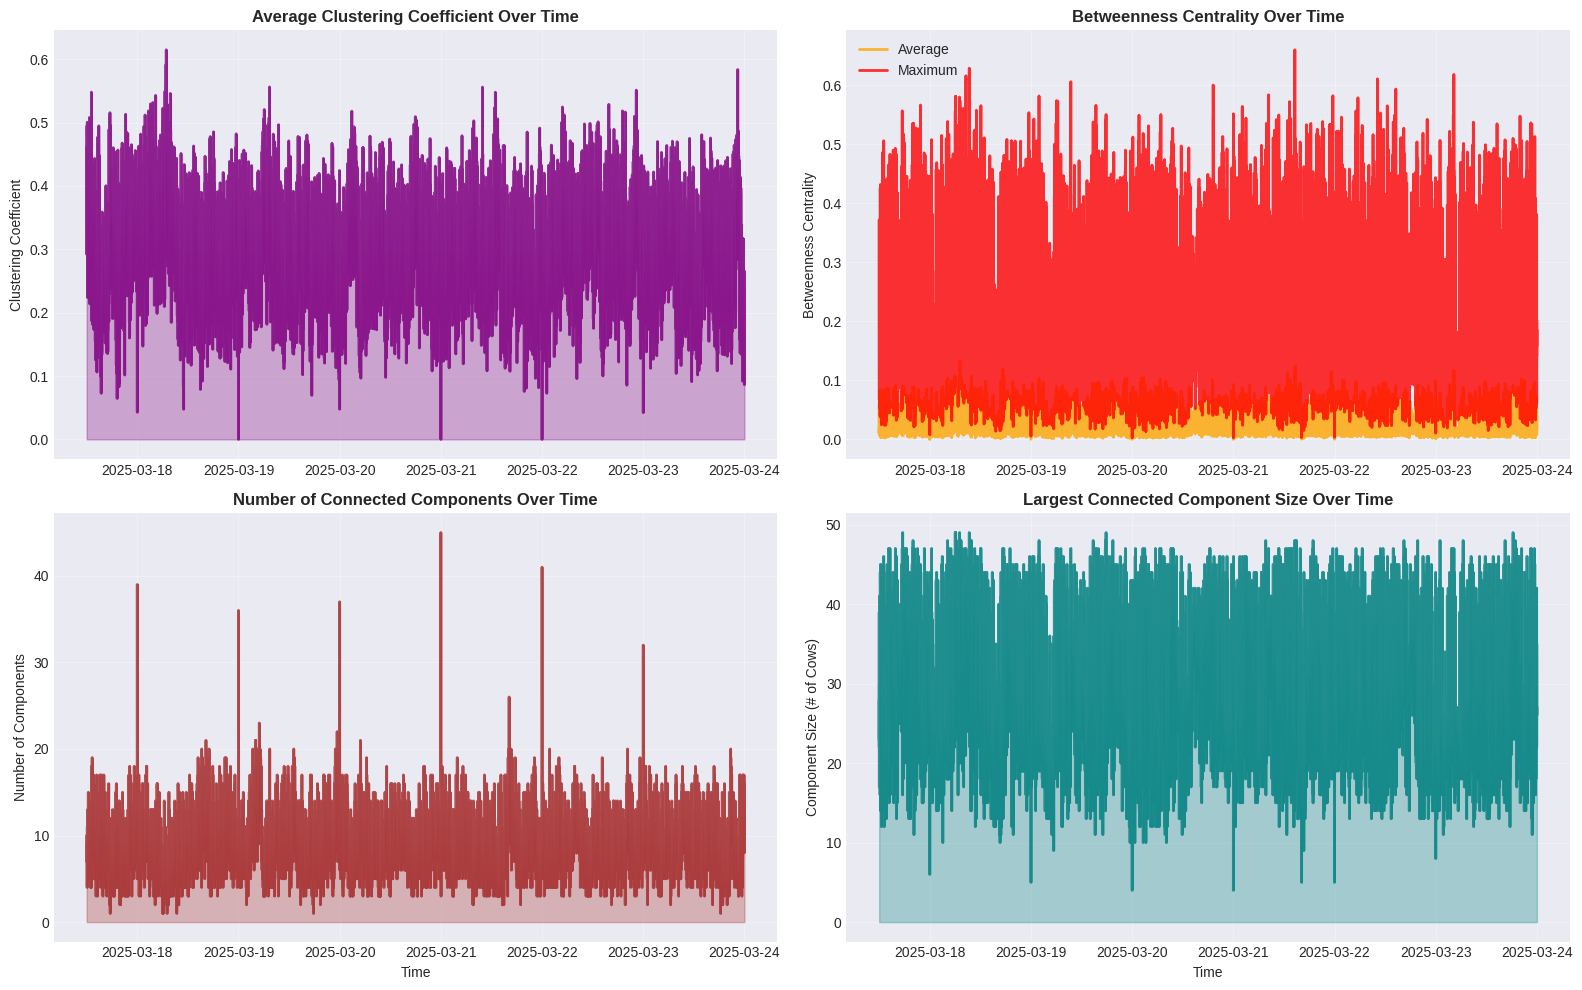

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Clustering coefficient
axes[0, 0].plot(metrics_df['timestamp'], metrics_df['avg_clustering'], 
                linewidth=2, color='purple', alpha=0.8)
axes[0, 0].fill_between(metrics_df['timestamp'], metrics_df['avg_clustering'], 
                         alpha=0.3, color='purple')
axes[0, 0].set_title('Average Clustering Coefficient Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Clustering Coefficient')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Betweenness centrality
axes[0, 1].plot(metrics_df['timestamp'], metrics_df['avg_betweenness'], 
                linewidth=2, color='orange', alpha=0.8, label='Average')
axes[0, 1].plot(metrics_df['timestamp'], metrics_df['max_betweenness'], 
                linewidth=2, color='red', alpha=0.8, label='Maximum')
axes[0, 1].set_title('Betweenness Centrality Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Betweenness Centrality')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Number of connected components
axes[1, 0].plot(metrics_df['timestamp'], metrics_df['num_components'], 
                linewidth=2, color='brown', alpha=0.8)
axes[1, 0].fill_between(metrics_df['timestamp'], metrics_df['num_components'], 
                         alpha=0.3, color='brown')
axes[1, 0].set_title('Number of Connected Components Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Components')
axes[1, 0].set_xlabel('Time')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Largest component size
axes[1, 1].plot(metrics_df['timestamp'], metrics_df['largest_component_size'], 
                linewidth=2, color='teal', alpha=0.8)
axes[1, 1].fill_between(metrics_df['timestamp'], metrics_df['largest_component_size'], 
                         alpha=0.3, color='teal')
axes[1, 1].set_title('Largest Connected Component Size Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Component Size (# of Cows)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Interactive Visualizations with Plotly

Create interactive time series plots for better exploration

In [10]:
# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Number of Edges', 'Network Density', 
                    'Average Clustering', 'Largest Component Size'),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Add traces
fig.add_trace(
    go.Scatter(x=summary_df['timestamp'], y=summary_df['num_edges'],
               mode='lines', name='Edges', line=dict(color='steelblue', width=2),
               fill='tozeroy', fillcolor='rgba(70, 130, 180, 0.3)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=summary_df['timestamp'], y=summary_df['density'],
               mode='lines', name='Density', line=dict(color='coral', width=2),
               fill='tozeroy', fillcolor='rgba(255, 127, 80, 0.3)'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=metrics_df['timestamp'], y=metrics_df['avg_clustering'],
               mode='lines', name='Clustering', line=dict(color='purple', width=2),
               fill='tozeroy', fillcolor='rgba(128, 0, 128, 0.3)'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=metrics_df['timestamp'], y=metrics_df['largest_component_size'],
               mode='lines', name='Component Size', line=dict(color='teal', width=2),
               fill='tozeroy', fillcolor='rgba(0, 128, 128, 0.3)'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="Interactive Network Metrics Dashboard",
    title_font_size=20,
    height=700,
    showlegend=False,
    hovermode='x unified'
)

fig.update_xaxes(title_text="Time", row=2, col=1)
fig.update_xaxes(title_text="Time", row=2, col=2)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Density", row=1, col=2)
fig.update_yaxes(title_text="Coefficient", row=2, col=1)
fig.update_yaxes(title_text="Cows", row=2, col=2)

fig.show()

print("✅ Interactive dashboard created! Hover over the plots to explore data.")

✅ Interactive dashboard created! Hover over the plots to explore data.


## 10. Degree Distribution Analysis

Analyze the degree distribution of nodes across all snapshots

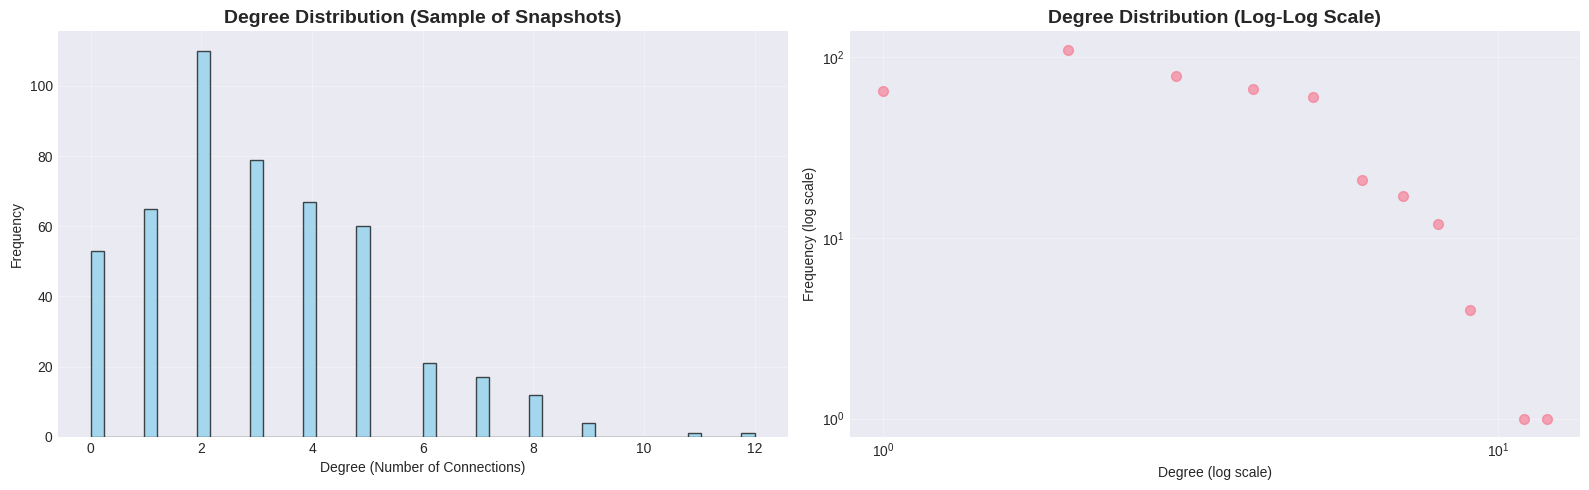

📊 Degree Statistics (from 10 snapshots):
   Average degree: 3.04
   Median degree: 3.00
   Max degree: 12
   Min degree: 0


In [11]:
# Collect degree distribution from a sample of snapshots
sample_indices = np.linspace(0, len(temporal_graphs)-1, min(10, len(temporal_graphs)), dtype=int)

all_degrees = []
for idx in sample_indices:
    G = temporal_graphs[idx]['graph']
    degrees = [deg for node, deg in G.degree()]
    all_degrees.extend(degrees)

# Plot degree distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(all_degrees, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Degree Distribution (Sample of Snapshots)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Degree (Number of Connections)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log-log plot to check for power law
degree_counts = pd.Series(all_degrees).value_counts().sort_index()
axes[1].scatter(degree_counts.index, degree_counts.values, alpha=0.6, s=50)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Degree Statistics (from {len(sample_indices)} snapshots):")
print(f"   Average degree: {np.mean(all_degrees):.2f}")
print(f"   Median degree: {np.median(all_degrees):.2f}")
print(f"   Max degree: {np.max(all_degrees)}")
print(f"   Min degree: {np.min(all_degrees)}")

## 11. Centrality Analysis - Most Influential Cows

Identify the most central/influential cows in the network

🏆 Top 10 Most Central Cows (by Average Degree Centrality):
cow_id  avg_degree_centrality  avg_betweenness_centrality  appearances  total_degree  total_betweenness
  3cf7               0.136177                    0.097774        18720   2549.229167        1830.323597
  3cfd               0.127059                    0.114722        18720   2378.541667        2147.602567
  3cf1               0.091772                    0.049056        18720   1717.979167         918.327213
  3668               0.088896                    0.069412        18720   1664.125000        1299.388164
  3cf8               0.081506                    0.039611        18720   1525.791667         741.519584
  3cee               0.076160                    0.053714        18720   1425.708333        1005.517040
  3d0c               0.072892                    0.031869        18720   1364.541667         596.581089
  3d02               0.071204                    0.033144        18720   1332.937500         620.450530
  3ce

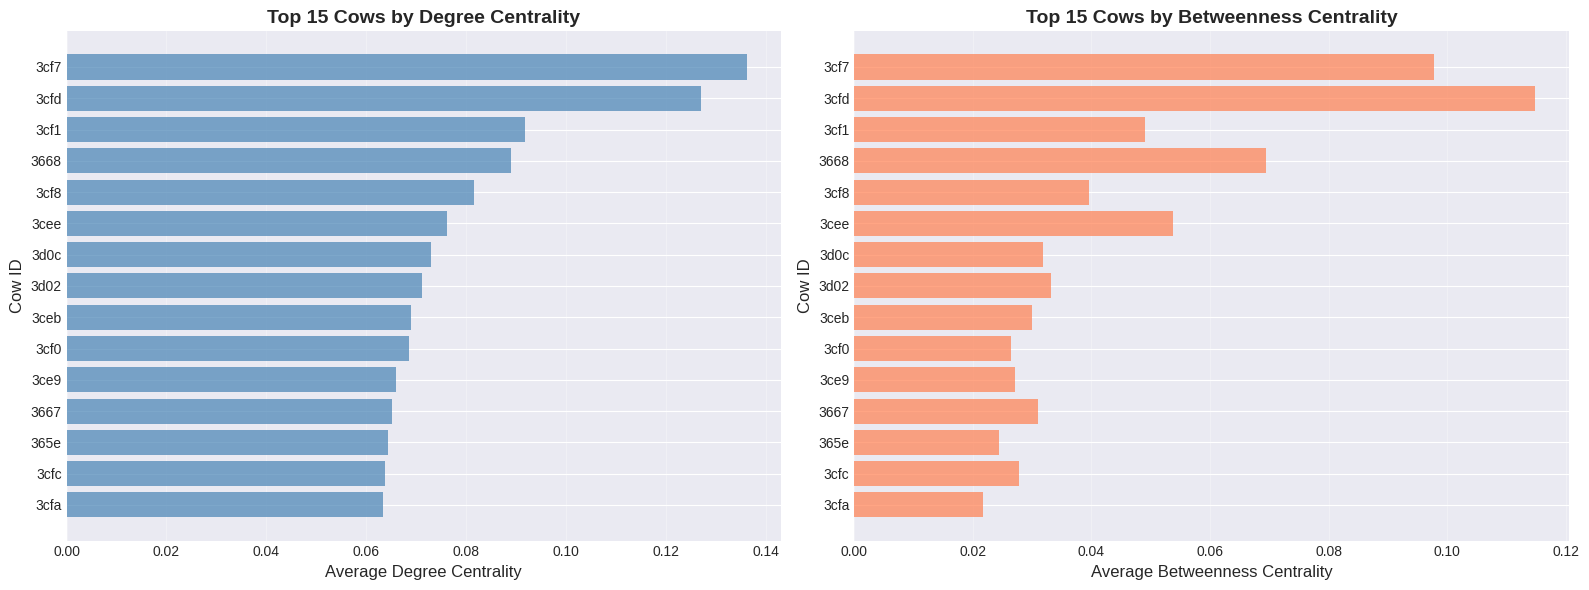

In [12]:
# Aggregate centrality across all snapshots
cow_centrality = {}

for snapshot in temporal_graphs:
    G = snapshot['graph']
    
    if G.number_of_edges() > 0:
        degree_cent = nx.degree_centrality(G)
        betweenness_cent = nx.betweenness_centrality(G)
        
        for cow in G.nodes():
            if cow not in cow_centrality:
                cow_centrality[cow] = {
                    'degree': [],
                    'betweenness': [],
                    'appearances': 0
                }
            
            cow_centrality[cow]['degree'].append(degree_cent[cow])
            cow_centrality[cow]['betweenness'].append(betweenness_cent[cow])
            cow_centrality[cow]['appearances'] += 1

# Calculate average centrality
centrality_summary = []
for cow, metrics in cow_centrality.items():
    centrality_summary.append({
        'cow_id': cow,
        'avg_degree_centrality': np.mean(metrics['degree']),
        'avg_betweenness_centrality': np.mean(metrics['betweenness']),
        'appearances': metrics['appearances'],
        'total_degree': sum(metrics['degree']),
        'total_betweenness': sum(metrics['betweenness'])
    })

centrality_df = pd.DataFrame(centrality_summary).sort_values('avg_degree_centrality', ascending=False)

print("🏆 Top 10 Most Central Cows (by Average Degree Centrality):")
print("="*70)
print(centrality_df.head(10).to_string(index=False))

# Visualize top cows
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_cows = centrality_df.head(15)

# Bar plot: Degree centrality
axes[0].barh(top_cows['cow_id'], top_cows['avg_degree_centrality'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Average Degree Centrality', fontsize=12)
axes[0].set_ylabel('Cow ID', fontsize=12)
axes[0].set_title('Top 15 Cows by Degree Centrality', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Bar plot: Betweenness centrality
axes[1].barh(top_cows['cow_id'], top_cows['avg_betweenness_centrality'], color='coral', alpha=0.7)
axes[1].set_xlabel('Average Betweenness Centrality', fontsize=12)
axes[1].set_ylabel('Cow ID', fontsize=12)
axes[1].set_title('Top 15 Cows by Betweenness Centrality', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 12. Network Visualization - Sample Snapshots

Visualize the network structure at different time points

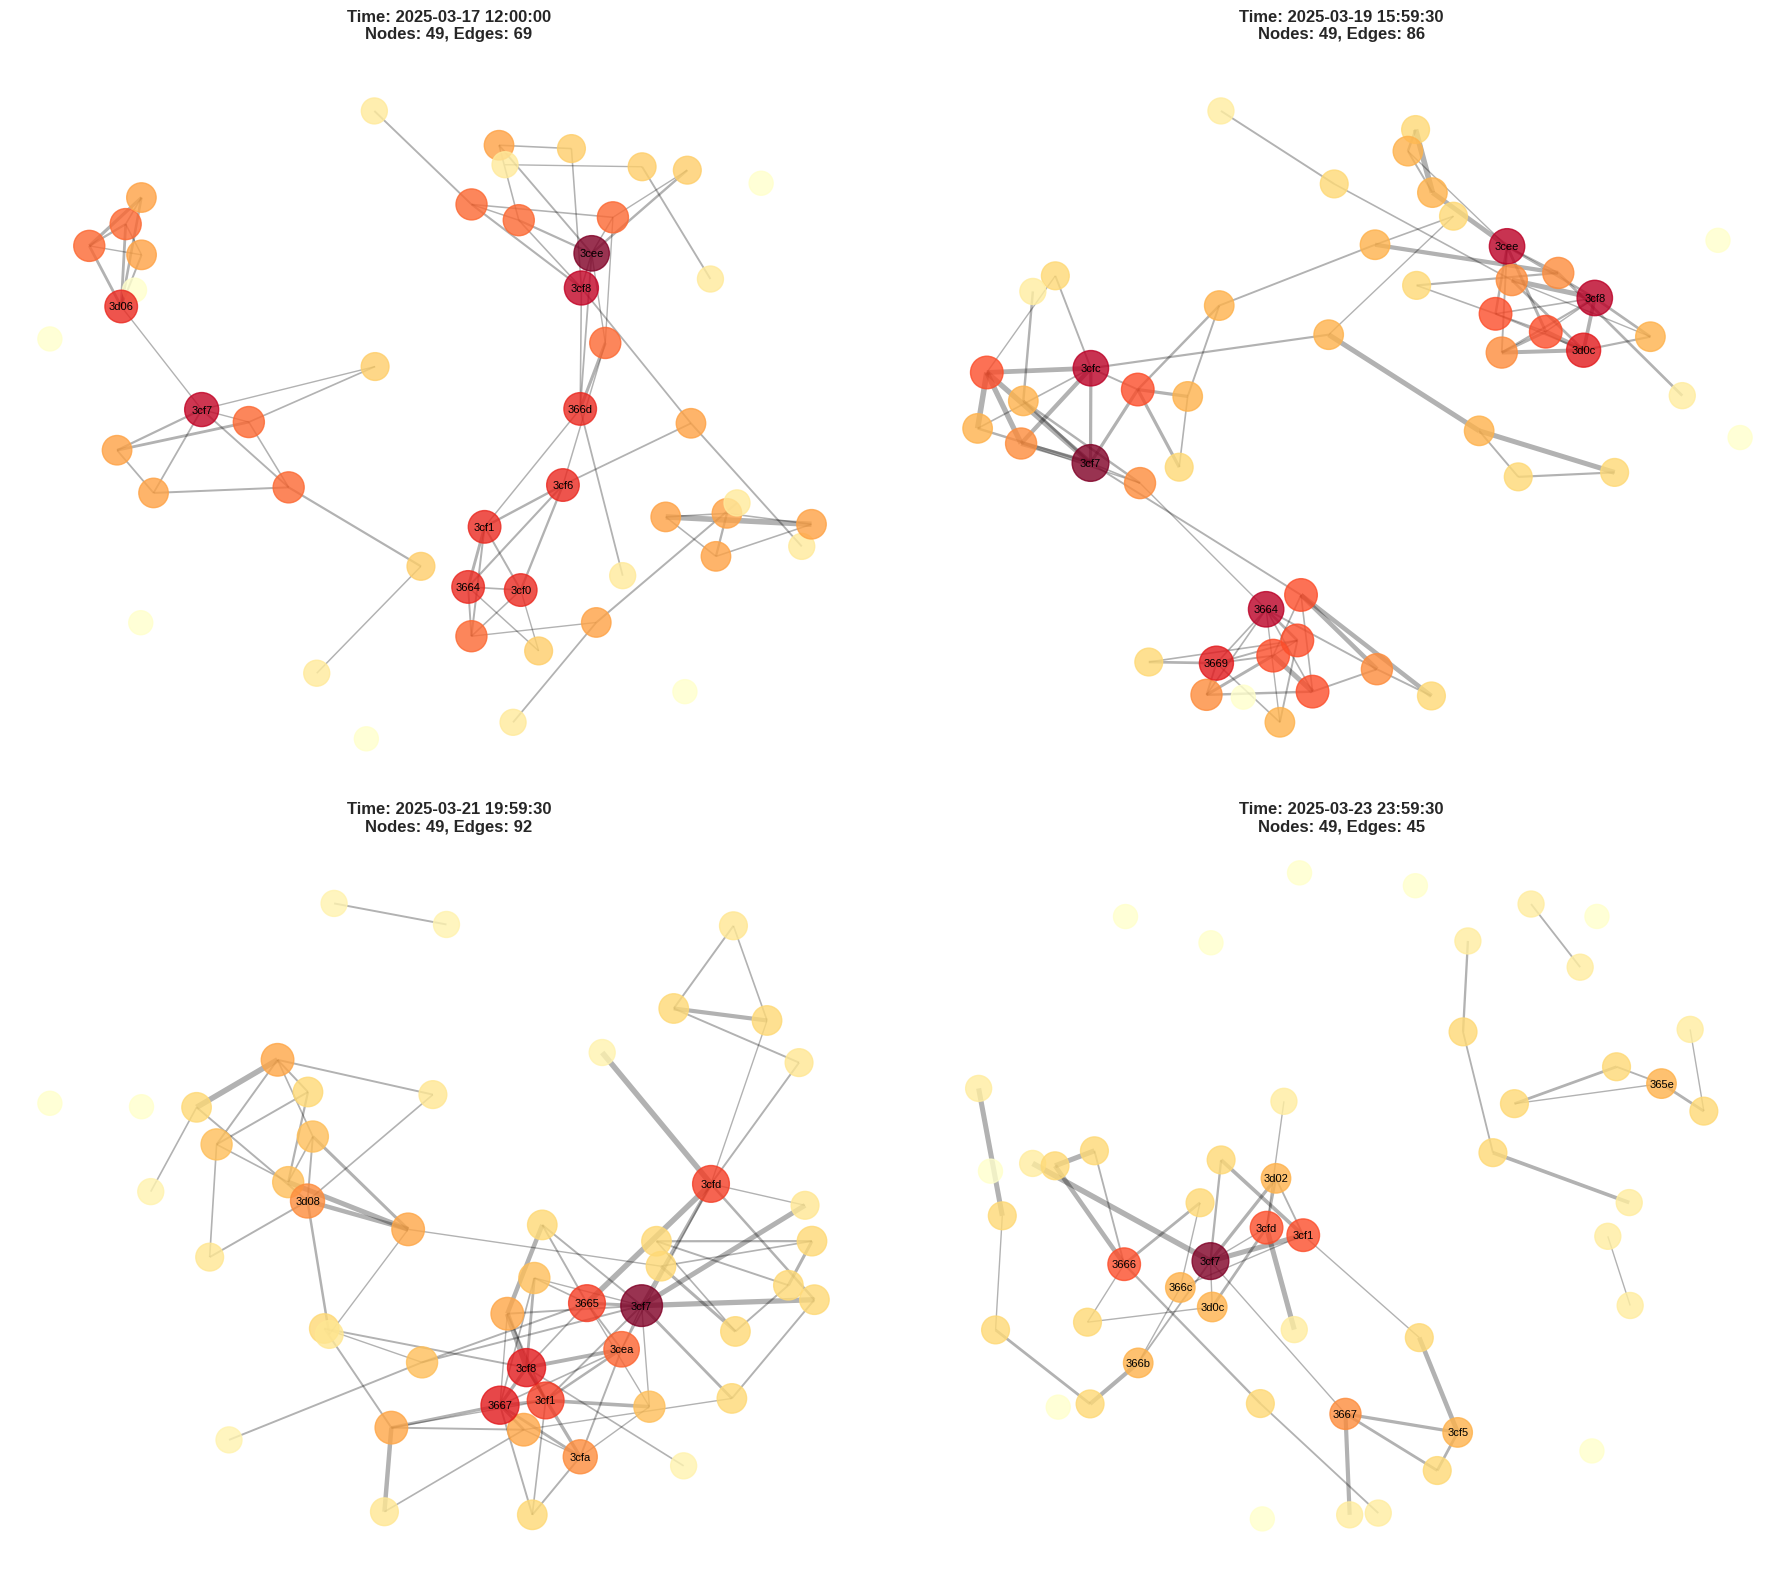

✅ Network visualizations created for 4 time points
   Node size = degree, Node color = degree (red = high), Edge thickness = RSSI strength


In [13]:
# Select 4 snapshots to visualize (evenly spaced)
num_snapshots_to_viz = 4
snapshot_indices = np.linspace(0, len(temporal_graphs)-1, num_snapshots_to_viz, dtype=int)

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, idx in enumerate(snapshot_indices):
    snapshot = temporal_graphs[idx]
    G = snapshot['graph']
    timestamp = snapshot['timestamp']
    
    # Use spring layout for positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Node sizes based on degree
    node_sizes = [300 + G.degree(node) * 50 for node in G.nodes()]
    
    # Node colors based on degree
    node_colors = [G.degree(node) for node in G.nodes()]
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           cmap='YlOrRd', alpha=0.8, ax=axes[i])
    
    # Draw edges with varying thickness based on RSSI
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v]['rssi'] for u, v in G.edges()]
        # Normalize edge weights for visualization
        max_weight = max(edge_weights) if edge_weights else 1
        min_weight = min(edge_weights) if edge_weights else 0
        weight_range = max_weight - min_weight if max_weight != min_weight else 1
        edge_widths = [1 + 3 * (w - min_weight) / weight_range for w in edge_weights]
        
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, ax=axes[i])
    
    # Draw labels for high-degree nodes only
    high_degree_nodes = [node for node in G.nodes() if G.degree(node) > np.percentile([G.degree(n) for n in G.nodes()], 75)]
    labels = {node: node for node in high_degree_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=axes[i])
    
    axes[i].set_title(f'Time: {timestamp}\nNodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}',
                      fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("✅ Network visualizations created for 4 time points")
print("   Node size = degree, Node color = degree (red = high), Edge thickness = RSSI strength")

## 13. Community Detection

Detect communities (groups of closely connected cows) in the network

🔍 Detecting communities in snapshot at 2025-03-23 06:34:00
   Graph has 49 nodes and 114 edges

✅ Detected 7 communities:
   Community 1: 1 cows - ['3cf3']
   Community 2: 14 cows - ['365e', '3cfd', '3d05', '3cf5', '3663']...
   Community 3: 11 cows - ['3d02', '3cec', '3d0f', '3660', '3d09']...
   Community 4: 1 cows - ['3662']
   Community 5: 15 cows - ['3ceb', '3cfa', '3cf1', '3669', '3cea']...
   Community 6: 1 cows - ['3cf9']
   Community 7: 6 cows - ['3cf8', '3cfc', '3cf4', '3cf0', '3ced']...


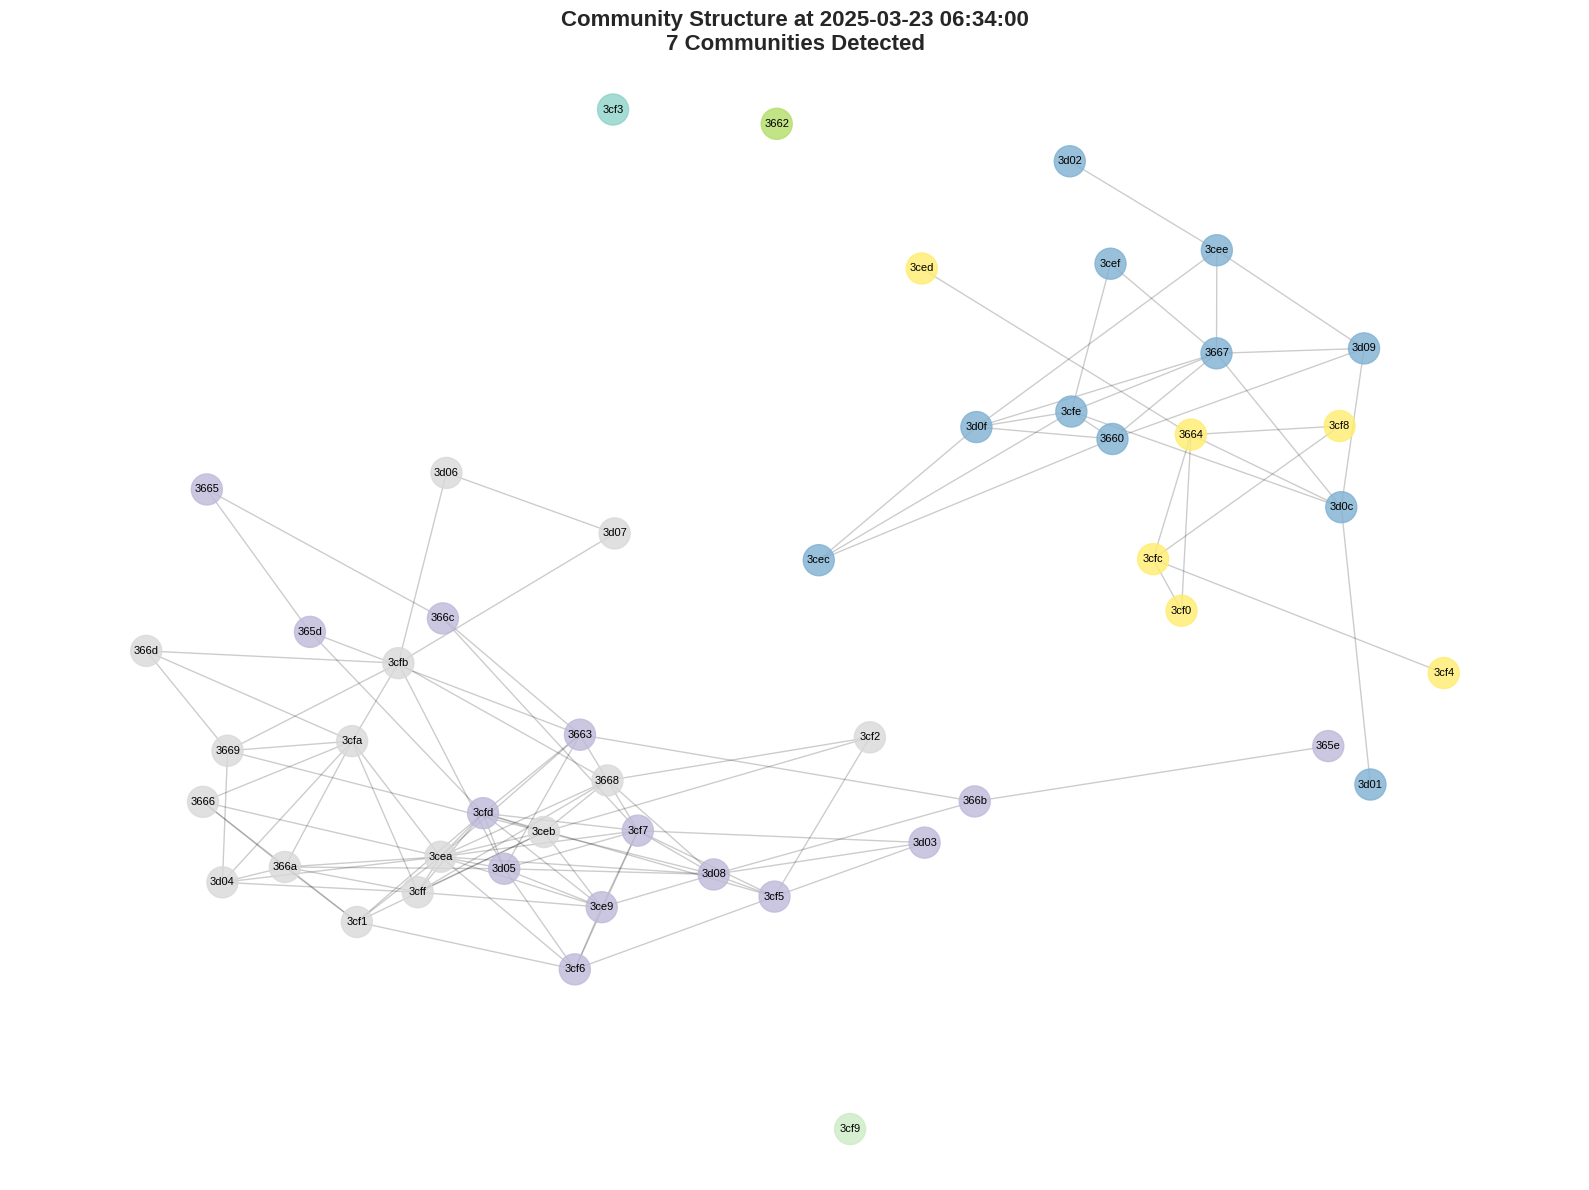

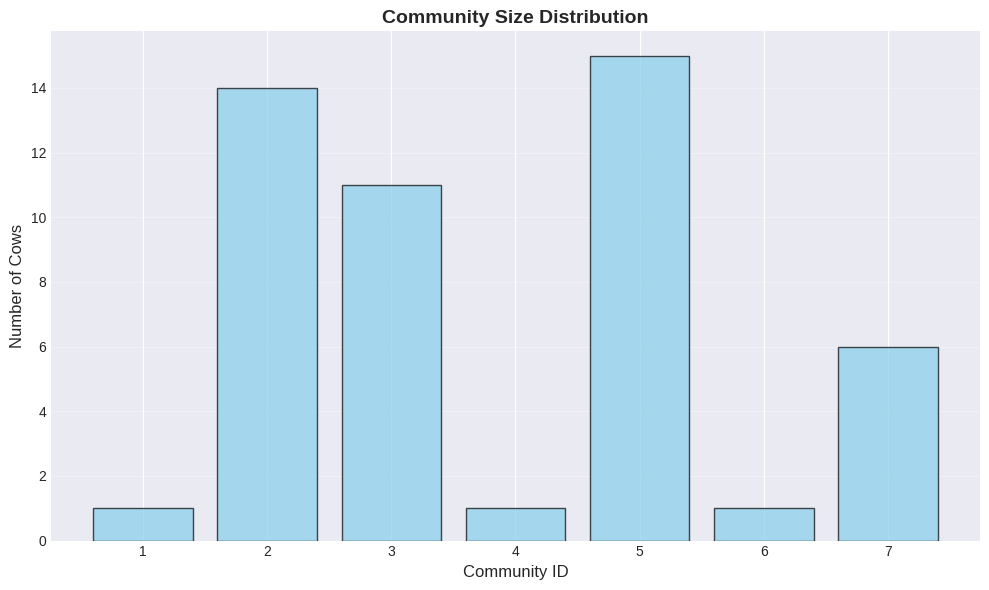

In [14]:
# Detect communities in a sample snapshot with many edges
# Find snapshot with maximum edges
max_edges_idx = summary_df['num_edges'].idxmax()
best_snapshot = temporal_graphs[max_edges_idx]
G_community = best_snapshot['graph']

print(f"🔍 Detecting communities in snapshot at {best_snapshot['timestamp']}")
print(f"   Graph has {G_community.number_of_nodes()} nodes and {G_community.number_of_edges()} edges")

if G_community.number_of_edges() > 0:
    # Detect communities using Louvain method
    communities = community.louvain_communities(G_community, seed=42)
    
    print(f"\n✅ Detected {len(communities)} communities:")
    for i, comm in enumerate(communities, 1):
        print(f"   Community {i}: {len(comm)} cows - {list(comm)[:5]}{'...' if len(comm) > 5 else ''}")
    
    # Visualize communities
    fig, ax = plt.subplots(figsize=(16, 12))
    
    pos = nx.spring_layout(G_community, k=0.5, iterations=50, seed=42)
    
    # Assign colors to communities
    node_colors = []
    color_map = {}
    colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
    
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = colors[i]
    
    node_colors = [color_map[node] for node in G_community.nodes()]
    
    # Draw network
    nx.draw_networkx_nodes(G_community, pos, node_color=node_colors, 
                           node_size=500, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G_community, pos, alpha=0.2, ax=ax)
    nx.draw_networkx_labels(G_community, pos, font_size=8, ax=ax)
    
    ax.set_title(f'Community Structure at {best_snapshot["timestamp"]}\n{len(communities)} Communities Detected',
                 fontsize=16, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Community size distribution
    community_sizes = [len(comm) for comm in communities]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(1, len(community_sizes)+1), community_sizes, color='skyblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Community ID', fontsize=12)
    ax.set_ylabel('Number of Cows', fontsize=12)
    ax.set_title('Community Size Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No edges in this snapshot - cannot detect communities")

## 14. Animated Network Evolution

Create an animation showing how the network evolves over time

In [15]:
print("🎬 Creating network animation...")
print("   Sampling snapshots for animation (every 10th snapshot)...")

# Sample snapshots for animation (to keep it manageable)
animation_step = max(1, len(temporal_graphs) // 100)  # Max 100 frames
selected_graphs = temporal_graphs[::animation_step]

print(f"   Selected {len(selected_graphs)} frames for animation")

# Use consistent node positions across all frames
# Aggregate all graphs to determine node positions
all_nodes = set()
for snapshot in selected_graphs:
    all_nodes.update(snapshot['graph'].nodes())

# Create a combined graph for layout
G_combined = nx.Graph()
G_combined.add_nodes_from(all_nodes)

# Use circular layout for consistency
circle_pos = nx.circular_layout(G_combined)

print("   Creating animation frames...")

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

def update(frame):
    ax.clear()
    
    snapshot = selected_graphs[frame]
    G = snapshot['graph']
    timestamp = snapshot['timestamp']
    
    # Draw nodes
    node_sizes = [300 + G.degree(node) * 30 for node in G.nodes()]
    node_colors = [G.degree(node) for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, circle_pos, node_size=node_sizes,
                           node_color=node_colors, cmap='YlOrRd',
                           alpha=0.8, ax=ax)
    
    # Draw edges
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v]['rssi'] for u, v in G.edges()]
        max_w = max(edge_weights) if edge_weights else 1
        min_w = min(edge_weights) if edge_weights else 0
        range_w = max_w - min_w if max_w != min_w else 1
        edge_widths = [0.5 + 2 * (w - min_w) / range_w for w in edge_weights]
        
        nx.draw_networkx_edges(G, circle_pos, width=edge_widths, alpha=0.3, ax=ax)
    
    # Title
    ax.set_title(f'Cow Proximity Network Evolution\nTime: {timestamp}\n'
                 f'Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}',
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    return ax,

# Create animation
anim = FuncAnimation(fig, update, frames=len(selected_graphs),
                     interval=200, blit=False, repeat=True)

# Save animation
output_gif = "outputs/network_evolution_animation.gif"
print(f"💾 Saving animation to {output_gif}...")

writer = PillowWriter(fps=5)
anim.save(output_gif, writer=writer)

plt.close()

print(f"✅ Animation saved! {len(selected_graphs)} frames at 5 FPS")
print(f"   File: {output_gif}")

🎬 Creating network animation...
   Sampling snapshots for animation (every 10th snapshot)...
   Selected 101 frames for animation
   Creating animation frames...
💾 Saving animation to outputs/network_evolution_animation.gif...
✅ Animation saved! 101 frames at 5 FPS
   File: outputs/network_evolution_animation.gif


## 15. Correlation Analysis

Analyze correlations between different network metrics

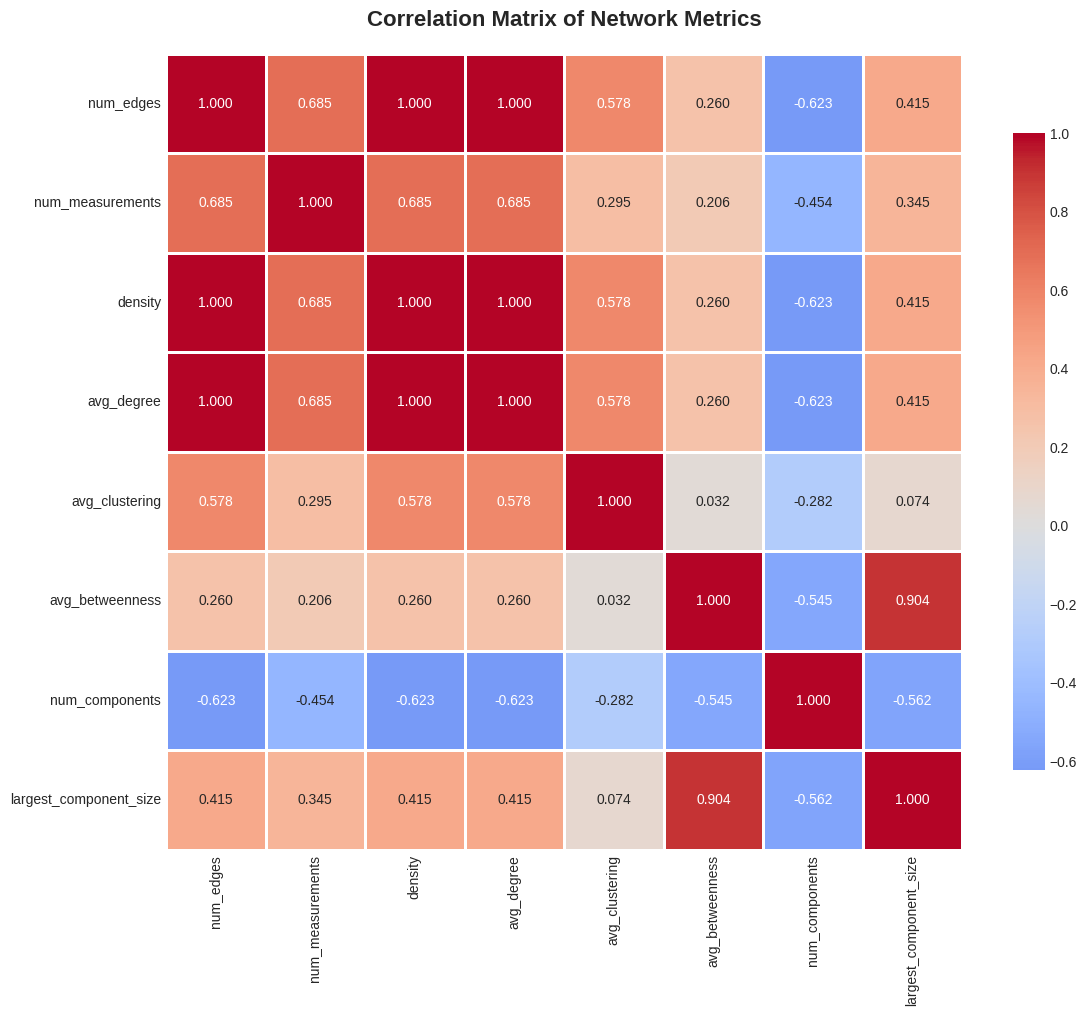

📊 Strong Correlations (|r| > 0.7):
   num_edges <-> density: 1.000
   num_edges <-> avg_degree: 1.000
   density <-> avg_degree: 1.000
   avg_betweenness <-> largest_component_size: 0.904


In [16]:
# Merge summary and metrics dataframes
combined_metrics = summary_df.merge(metrics_df, on='timestamp')

# Select numerical columns for correlation
corr_columns = ['num_edges', 'num_measurements', 'density', 'avg_degree', 
                'avg_clustering', 'avg_betweenness', 'num_components', 'largest_component_size']

correlation_matrix = combined_metrics[corr_columns].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_title('Correlation Matrix of Network Metrics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("📊 Strong Correlations (|r| > 0.7):")
print("="*60)
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            print(f"   {corr_columns[i]} <-> {corr_columns[j]}: {corr_value:.3f}")

## 16. Temporal Pattern Analysis

Analyze patterns over time (hourly, daily cycles)

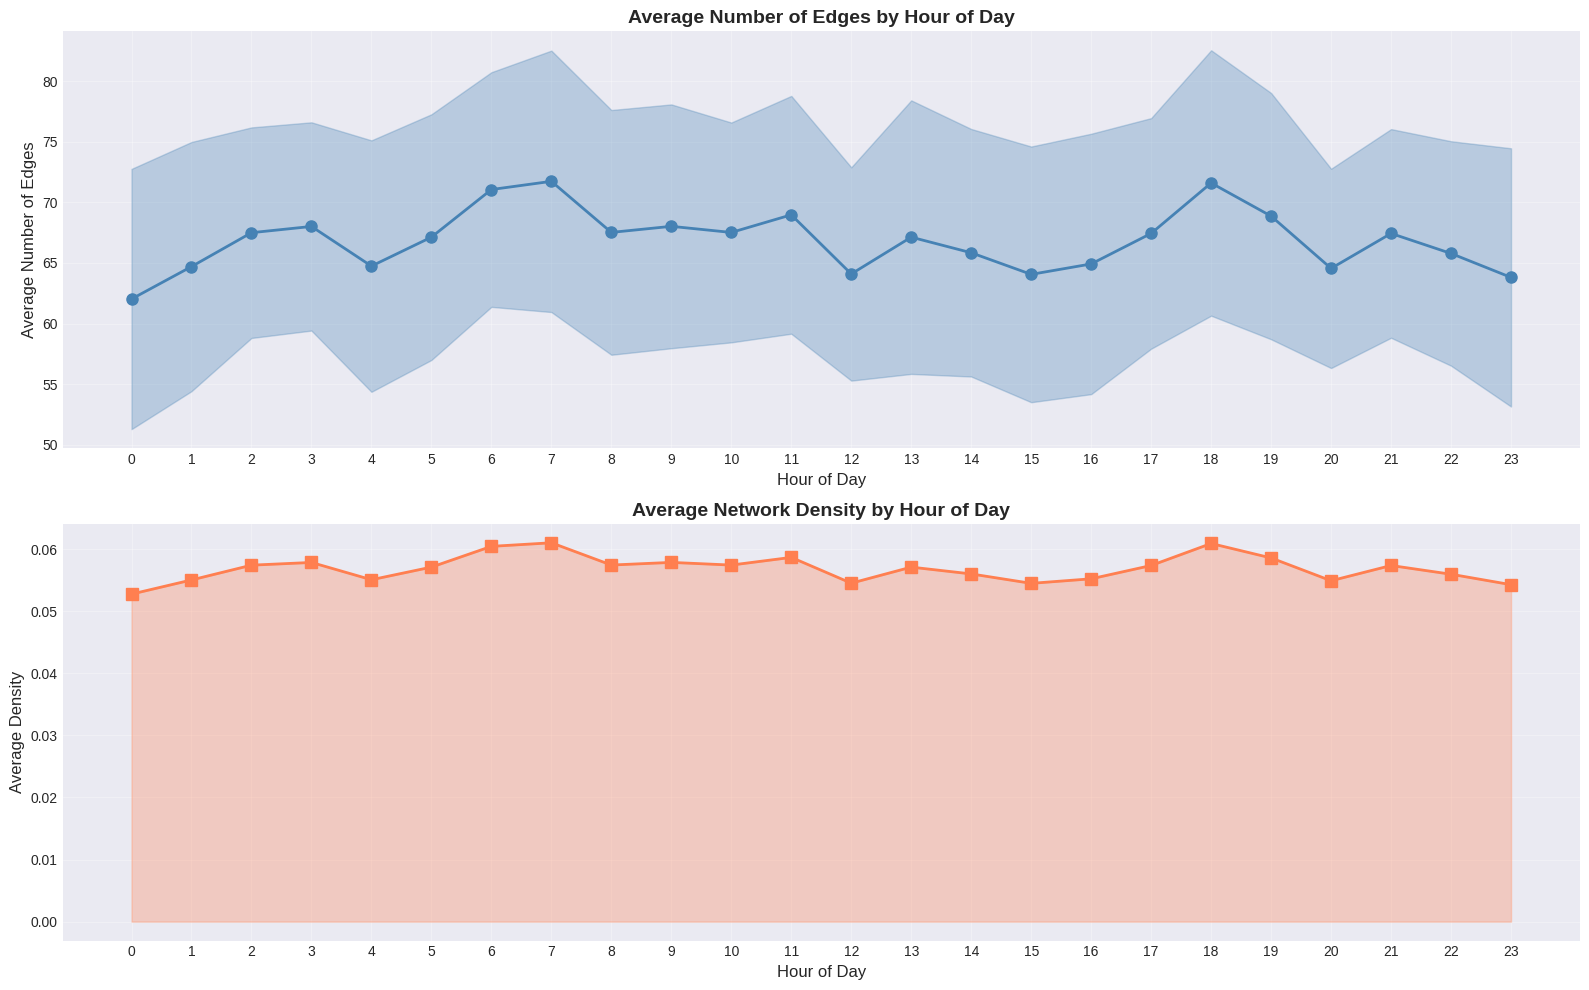

📊 Peak Activity Hours:
   Most edges: Hour 7:00
   Highest density: Hour 7:00

📊 Low Activity Hours:
   Fewest edges: Hour 0:00
   Lowest density: Hour 0:00


In [17]:
# Extract time features
summary_df['hour'] = summary_df['timestamp'].dt.hour
summary_df['day_of_week'] = summary_df['timestamp'].dt.day_name()
summary_df['date'] = summary_df['timestamp'].dt.date

# Hourly patterns
hourly_stats = summary_df.groupby('hour').agg({
    'num_edges': ['mean', 'std'],
    'density': 'mean',
    'avg_degree': 'mean'
}).reset_index()

hourly_stats.columns = ['hour', 'avg_edges', 'std_edges', 'avg_density', 'avg_degree']

# Plot hourly patterns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Edges by hour
axes[0].plot(hourly_stats['hour'], hourly_stats['avg_edges'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].fill_between(hourly_stats['hour'], 
                      hourly_stats['avg_edges'] - hourly_stats['std_edges'],
                      hourly_stats['avg_edges'] + hourly_stats['std_edges'],
                      alpha=0.3, color='steelblue')
axes[0].set_title('Average Number of Edges by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Average Number of Edges', fontsize=12)
axes[0].set_xticks(range(24))
axes[0].grid(True, alpha=0.3)

# Density by hour
axes[1].plot(hourly_stats['hour'], hourly_stats['avg_density'], 
             marker='s', linewidth=2, markersize=8, color='coral')
axes[1].fill_between(hourly_stats['hour'], hourly_stats['avg_density'], 
                      alpha=0.3, color='coral')
axes[1].set_title('Average Network Density by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Average Density', fontsize=12)
axes[1].set_xticks(range(24))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Peak Activity Hours:")
peak_edges_hour = hourly_stats.loc[hourly_stats['avg_edges'].idxmax(), 'hour']
peak_density_hour = hourly_stats.loc[hourly_stats['avg_density'].idxmax(), 'hour']
print(f"   Most edges: Hour {int(peak_edges_hour)}:00")
print(f"   Highest density: Hour {int(peak_density_hour)}:00")

print("\n📊 Low Activity Hours:")
low_edges_hour = hourly_stats.loc[hourly_stats['avg_edges'].idxmin(), 'hour']
low_density_hour = hourly_stats.loc[hourly_stats['avg_density'].idxmin(), 'hour']
print(f"   Fewest edges: Hour {int(low_edges_hour)}:00")
print(f"   Lowest density: Hour {int(low_density_hour)}:00")

## 17. Summary Report

Generate a comprehensive summary of the analysis

In [18]:
print("="*80)
print("📊 TEMPORAL GRAPH DATASET ANALYSIS SUMMARY")
print("="*80)

print(f"\n📁 Dataset Information:")
print(f"   File: {BASE_FILENAME}")
print(f"   RSSI Threshold: {metadata['rssi_threshold']} dB")
print(f"   Snapshot Duration: {metadata['snapshot_duration']} seconds")
print(f"   Aggregation Method: {metadata['aggregation']}")
print(f"   Time Range: {metadata['start_time']} to {metadata['end_time']}")

print(f"\n📈 Network Statistics:")
print(f"   Total Snapshots: {len(temporal_graphs)}")
print(f"   Total Nodes (Cows): {metadata['total_nodes']}")
print(f"   Average Edges per Snapshot: {summary_df['num_edges'].mean():.2f}")
print(f"   Max Edges in a Snapshot: {summary_df['num_edges'].max()}")
print(f"   Min Edges in a Snapshot: {summary_df['num_edges'].min()}")
print(f"   Average Network Density: {summary_df['density'].mean():.4f}")
print(f"   Average Degree per Cow: {summary_df['avg_degree'].mean():.2f}")

print(f"\n🌐 Advanced Metrics:")
print(f"   Average Clustering Coefficient: {metrics_df['avg_clustering'].mean():.4f}")
print(f"   Average Number of Components: {metrics_df['num_components'].mean():.2f}")
print(f"   Average Largest Component Size: {metrics_df['largest_component_size'].mean():.2f} cows")

print(f"\n🏆 Most Central Cows:")
top_3_cows = centrality_df.head(3)
for idx, row in top_3_cows.iterrows():
    print(f"   {row['cow_id']}: Degree Centrality = {row['avg_degree_centrality']:.4f}")

print(f"\n⏰ Temporal Patterns:")
print(f"   Peak Activity Hour: {int(peak_edges_hour)}:00 ({hourly_stats.loc[hourly_stats['hour']==peak_edges_hour, 'avg_edges'].values[0]:.1f} avg edges)")
print(f"   Low Activity Hour: {int(low_edges_hour)}:00 ({hourly_stats.loc[hourly_stats['hour']==low_edges_hour, 'avg_edges'].values[0]:.1f} avg edges)")

print(f"\n📊 Outputs Generated:")
print(f"   ✅ Time series plots")
print(f"   ✅ Distribution analysis")
print(f"   ✅ Network visualizations")
print(f"   ✅ Community detection")
print(f"   ✅ Centrality analysis")
print(f"   ✅ Correlation heatmap")
print(f"   ✅ Animated network evolution")
print(f"   ✅ Temporal pattern analysis")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)

📊 TEMPORAL GRAPH DATASET ANALYSIS SUMMARY

📁 Dataset Information:
   File: temporal_graphs_rssi-75.0_snap30s_max_20251112_102656
   RSSI Threshold: -75.0 dB
   Snapshot Duration: 30 seconds
   Aggregation Method: max
   Time Range: 2025-03-17 12:00:00 to 2025-03-23 23:59:30

📈 Network Statistics:
   Total Snapshots: 18720
   Total Nodes (Cows): 49
   Average Edges per Snapshot: 66.81
   Max Edges in a Snapshot: 114
   Min Edges in a Snapshot: 4
   Average Network Density: 0.0568
   Average Degree per Cow: 2.73

🌐 Advanced Metrics:
   Average Clustering Coefficient: 0.3037
   Average Number of Components: 9.36
   Average Largest Component Size: 28.94 cows

🏆 Most Central Cows:
   3cf7: Degree Centrality = 0.1362
   3cfd: Degree Centrality = 0.1271
   3cf1: Degree Centrality = 0.0918

⏰ Temporal Patterns:
   Peak Activity Hour: 7:00 (71.7 avg edges)
   Low Activity Hour: 0:00 (62.0 avg edges)

📊 Outputs Generated:
   ✅ Time series plots
   ✅ Distribution analysis
   ✅ Network visualizati